In [1]:
import sys
print(sys.executable)

/home/axeltanjung/datascience/bayes_project/.venv/bin/python


In [2]:
!pip install pymc xarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 KB 652.5 kB/s eta 0:00:000:00:010:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.7 MB/s eta 0:00:003.6 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 5.9 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.1 MB/s eta 0:00:000:00:010:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.6/241.6 KB 4.6 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 4.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.6 MB/s eta 0:00:006.0 MB/s eta 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 5.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr

warnings.filterwarnings("ignore", module="scipy")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


In [8]:
data = pd.read_csv("../dataset/concrete_date.csv")

In [19]:
numerical_features = ['cement', 'slag', 'flyash', 'water', 'superplasticizer',
                     'coarseaggregate', 'fineaggregate', 'age']

## Before Fitting Model

### 1. Exploratory Data Analysis 


First we need to understand our variable relation with what we are going to predict



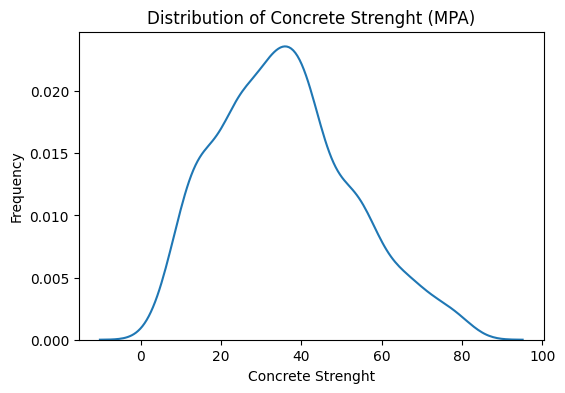

In [11]:
# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.kdeplot(data['csMPa'])
plt.title('Distribution of Concrete Strenght (MPA)')
plt.xlabel('Concrete Strenght')
plt.ylabel('Frequency')
plt.show()

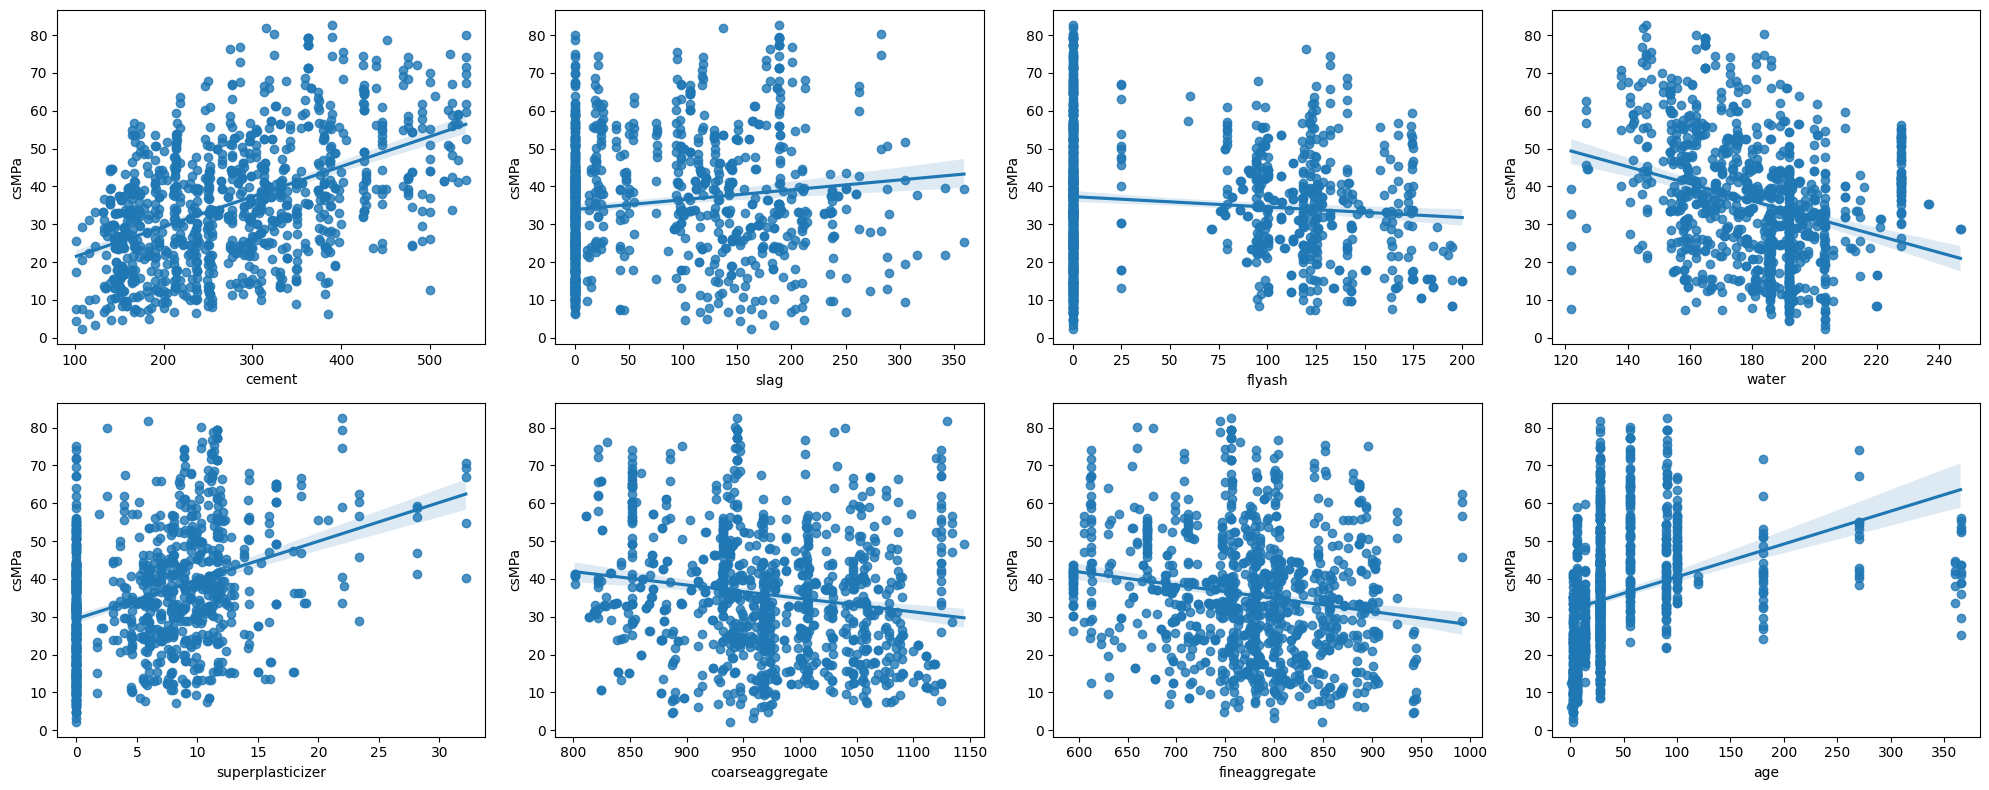

In [24]:
# Assume numerical_features is a list of feature names
num_features = len(numerical_features)
num_cols = (num_features + 1) // 2  # Determine the number of columns in each row
num_rows = 2  # Two rows

# Create subplots with the desired number of rows and columns
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 8))

# Flatten the axes array for easier indexing
ax = ax.flatten()

# Plot each feature
for idx in range(num_features):
    sns.regplot(data=data, x=numerical_features[idx], y="csMPa", ax=ax[idx])

# Hide any unused subplots if the number of features is less than the number of subplot slots
for idx in range(num_features, len(ax)):
    ax[idx].axis('off')

plt.tight_layout()
plt.show()

### 2. Choosing Initial Model 

There are lot of varity of model we can use, however ar first we should try the simplest one at first, for example we can use the cement to predict the concrete strenght

**Simple Model**

$strenght =  \alpha + \beta * cement$

### 3. Scaling and Transforming Parameter 



Why then scaling needed ? 
For easier choose of prior we can perform scaling, for example if we normalized our data into $X \sim Normal(\mu=1,\sigma=1)$ 


1. Scale Free --> ease at spesifying prior , we can use such standard normal prior
2. Interpretation --> for example we want to scale the outcome as we want to explain / interpret the regression coefficient in terms of log scale which are more intuitive


now, let's scale both our predictor and outcome variables to log scale 

In [26]:
data['log_csMPa'] = np.log(data['csMPa'])
data['log_cement'] = np.log(data['cement'])

Text(0.5, 1.0, 'Original Scale')

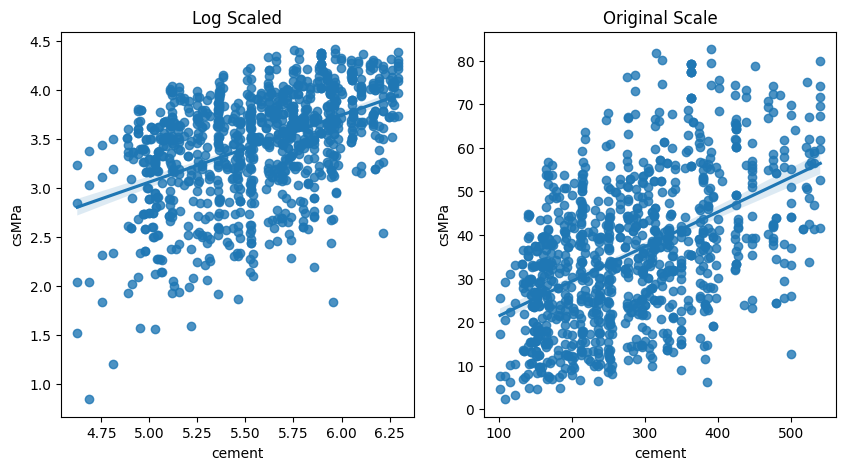

In [27]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.regplot(x=np.log(data['cement']),y=np.log(data['csMPa']),ax=ax[0])
sns.regplot(x=data['cement'],y=data['csMPa'],ax=ax[1])


ax[0].set_title('Log Scaled')
ax[1].set_title('Original Scale')

So how to choose our prior ? 

From that we can see that the slope ranges from 1 to 2 , we can specify our model 


$$
\begin{align}
log(rides) & \sim Normal(\mu,\sigma) \text{ [likelihood]} \\
\mu &= \alpha + \beta *log(\text{tempactual}_i) \\ 
\alpha & \sim Normal(\mu = 2,\sigma =1) \text{ [prior]} \\
\beta & \sim Normal(\mu = 2,\sigma =1) \text{ [prior]} \\
\sigma & \sim Expon(\lambda = 2)\text{ [prior]} \\
\end{align}
$$


**Likelihood** 

We need to decide which likelihood we are using , we can check the `logcmpa` distribution

<Axes: xlabel='log_csMPa', ylabel='Density'>

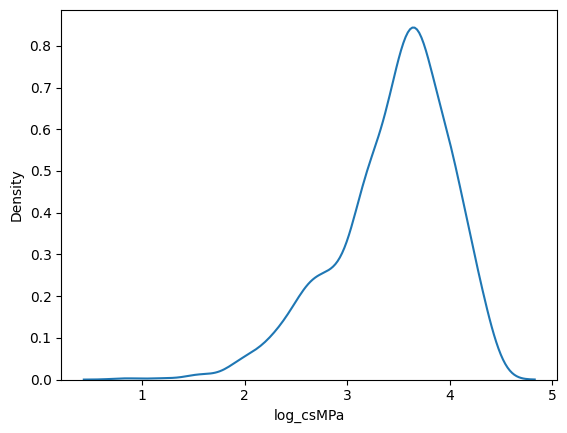

In [29]:
sns.kdeplot(data=data,x='log_csMPa')

we have tails on our data, or skewed data, okay we can check avalaible distribution in pymc 

**Skew Normal Distribution**

![skew normal](https://www.pymc.io/projects/docs/en/latest/_images/pymc-SkewNormal-1.png)

**Student T Distribution**

![Student T](https://www.pymc.io/projects/docs/en/latest/_images/pymc-StudentT-1.png)

In [ ]:
with pm.Model() as strenght_model1 :
#
  a = pm.Normal('a',0,0.5)
  b = pm.Normal('b',0,1)
  sigma = pm.Exponential('sigma',0.5)

  # likelihood

  linear_model = pm.Deterministic('mu',a + b * data['log_cement'].values)
  likelihood = pm.Normal('logcsmpa',mu=linear_model,sigma=sigma,observed=data['log_csMPa'].values)

### 4. Prior Predictive Checking


Next, let's measure how our prior prediction looks like. 
Some steps 



In [50]:
with strenght_model1 :
      strenght_model1_prior = pm.sample_prior_predictive(draws=100)

Sampling: [a, b, logcsmpa, mu, sigma]


Text(0.5, 1.0, 'Prior Prediction Plot using Original scale')

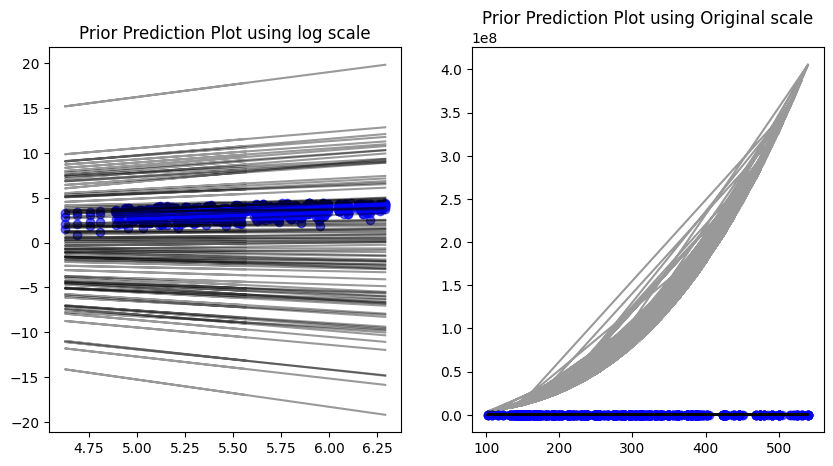

In [51]:
shape_prior_samples = strenght_model1_prior.prior['a'].values.flatten().shape[0]
n_data = data.shape[0] 
csmpa_pred = np.zeros(( n_data , shape_prior_samples ))



for i, val in enumerate(data['log_cement']):
    # dont forget to inverse 
    csmpa_pred[i] = strenght_model1_prior.prior["a"] + strenght_model1_prior.prior["b"]  * val

inverse_scaled_csmpa = np.exp(csmpa_pred)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
for i in range(shape_prior_samples) : 
    ax[0].plot(data['log_cement'],csmpa_pred[:,i], c="k", alpha=0.4)

ax[0].scatter(data['log_cement'],data['log_csMPa'], c="blue", alpha=0.6)
ax[0].set_title('Prior Prediction Plot using log scale')



for i in range(shape_prior_samples) : 
    ax[1].plot(data['cement'],inverse_scaled_csmpa[:,i], c="k", alpha=0.4)

ax[1].scatter(data['cement'],data['csMPa'], c="blue", alpha=0.6)
ax[1].set_title('Prior Prediction Plot using Original scale')

Our prior still have some limitation, which there is some sample of data that are far from our observed data

## Fitting Model

Now its time to fit our model --> it means sampling from posterior


#### Adding Random Number Generator

Before we start fitting our we need to setup what is called as **random number** generator like random_state in scikit-learn. Why ? 

Because we want each time we run the model, the result is pretty consistent


The key is **reproducibility** 

In [52]:
RANDOM_SEED = 42

In [ ]:
with strenght_model1 :
  strenght_model1_trace = pm.sample(2000, random_seed=RANDOM_SEED)

### 5. Checking Model Inference Process


One of the core powerful tool that can estimate posterior distribution is our sampling algorithm. 


The Inference / Posterior Sampling Process is not simply like `model.fit()` . 

Our MCMC algorithm may lead to suboptimal result. Hence it's important to check whether our sampling / trace works properly. 


So what is the definition of proper? 

To check whether during there is / are problem when fitting the model we can check the trace of each sample generated for our parameters

To do so , we can use `arviz.plot_trace` 

#### Plotting Trace

In [36]:
az.plot_trace(strenght_model1_trace, var_names=('a','b','sigma'))

NameError: name 'strenght_model1_trace' is not defined